In [1]:
import numpy as np
import os
import cv2
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

#### Specifying load directories for the dataset

In [2]:
DATADIR = "D:/Projects/Malaria/cell_images/"
infected = os.path.join(DATADIR, "Parasitized/")
uninfected = os.path.join(DATADIR, "Uninfected/")

In [7]:
img_path = os.listdir(infected)

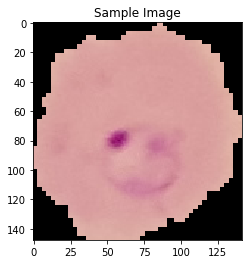

In [20]:
sample_img = plt.imread(infected + img_path[0])
plt.title("Sample Image")
plt.imshow(sample_img)

## Introducing Noise to Image
image : ndarray
    Input image data. Will be converted to float.

mode : str
    One of the following strings, selecting the type of noise to add:

    'gauss'     Gaussian-distributed additive noise.
    'poisson'   Poisson-distributed noise generated from the data.
    's&p'       Replaces random pixels with 0 or 1.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.

In [5]:
def noisy(noise_typ, image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy

    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out

    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy

    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

#### Adding several kinds of noises to a sample image from the dataset

c:\users\acer\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
c:\users\acer\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


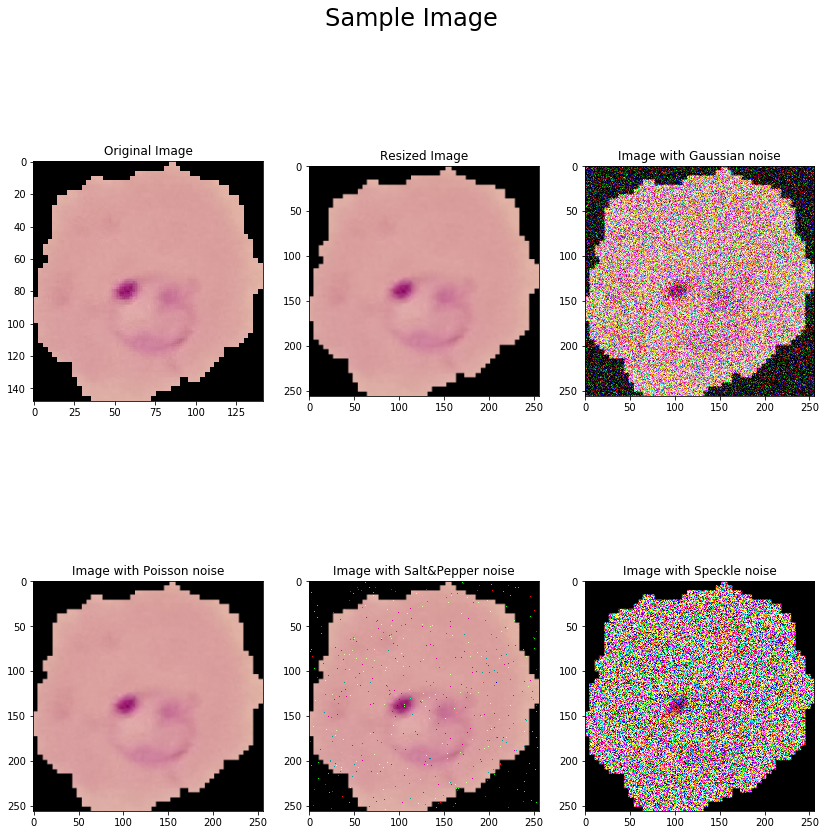

In [9]:
fig = plt.figure(figsize=(14,14))
fig.suptitle('Sample Image', fontsize=24)
rows = 2
columns = 3

img_resize = cv2.resize(sample_img, (256, 256))
gauss_img = noisy('gauss', img_resize)
poisson_img = noisy('poisson', img_resize)
sp_img = noisy('s&p', img_resize)
speckle_img = noisy('speckle', img_resize)

fig.add_subplot(rows, columns, 1)
plt.title('Original Image')
plt.imshow(sample_img)
fig.add_subplot(rows, columns, 2)
plt.title('Resized Image')
plt.imshow(img_resize)
fig.add_subplot(rows, columns, 3)
plt.title('Image with Gaussian noise')
plt.imshow(gauss_img)
fig.add_subplot(rows, columns, 4)
plt.title('Image with Poisson noise')
plt.imshow(poisson_img)
fig.add_subplot(rows, columns, 5)
plt.title('Image with Salt&Pepper noise')
plt.imshow(sp_img)
fig.add_subplot(rows, columns, 6)
plt.title('Image with Speckle noise')
plt.imshow(speckle_img)

## Image Restoration
Passing noisy images thorugh several different filters

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


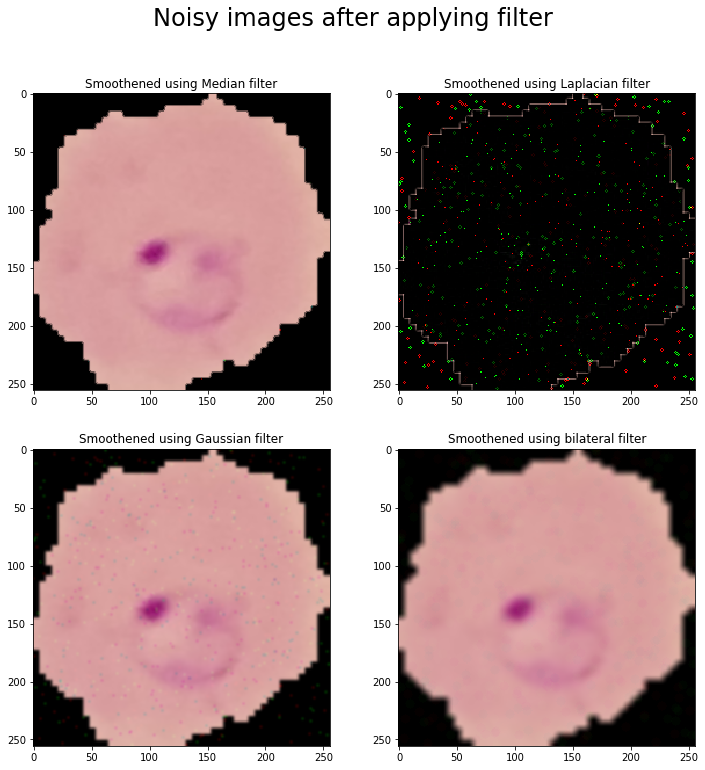

In [19]:
fig = plt.figure(figsize=(12,12))
fig.suptitle('Noisy images after applying filter', fontsize=24)
rows = 2
columns = 2
median = cv2.medianBlur(sp_img, 3)
fig.add_subplot(rows, columns, 1)
plt.title('Smoothened using Median filter')
plt.imshow(median)
laplacian = cv2.Laplacian(sp_img, 5)
fig.add_subplot(rows, columns, 2)
plt.title('Smoothened using Laplacian filter')
plt.imshow(laplacian)
gaussian = cv2.GaussianBlur(sp_img, (5,5),0)
fig.add_subplot(rows, columns, 3)
plt.title('Smoothened using Gaussian filter')
plt.imshow(gaussian)
bilateral = cv2.bilateralFilter(sp_img, 9,75,75)
fig.add_subplot(rows, columns, 4)
plt.title('Smoothened using bilateral filter')
plt.imshow(bilateral)

## Image Segmentaion
In this, the algorithm calculate the threshold for a small regions of the image. So we get different thresholds for different regions of the same image and it gives us better results for images with varying illumination.

Adaptive Method - It decides how thresholding value is calculated.
- cv2.ADAPTIVE_THRESH_MEAN_C : threshold value is the mean of neighbourhood area.
- cv2.ADAPTIVE_THRESH_GAUSSIAN_C : threshold value is the weighted sum of neighbourhood values where weights are a gaussian window.

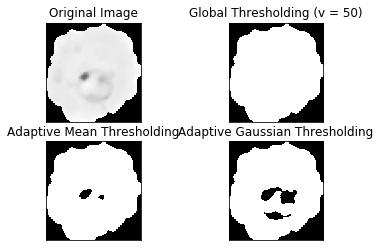

In [18]:
img = cv2.imread(infected + img_path[0], 0)
img = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img,50,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,121,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,121,2)

titles = ['Original Image', 'Global Thresholding (v = 50)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

### Creating a new dataset of training images
1. Resizing images for faster training
1. Adding noise
1. Restoring using Median filter

In [ ]:
IMAGE_SIZE = (256, 256)
n_type = 's&p'
noisy_output = os.path.join(DATADIR, "noisy_train_images")

def create_noisy_train_image():
        for index in df.index:
                image = cv2.imread(df.image_path[index])
                image = cv2.resize(image, IMAGE_SIZE)
                image = noisy(n_type, image)
                image = cv2.medianBlur(image, 3)
                cv2.imwrite((os.path.join(noisy_output, df.Image_name[index]) + '.jpg'), image)

create_noisy_train_image()